In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import awkward as ak
import correctionlib as cl
from coffea.lookup_tools import extractor
import uproot
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.colors as colors
import correctionlib.schemav2 as cs
import correctionlib as cl


import matplotlib
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
import os
#matplotlib.use('pgf')
#from matplotlib.backends.backend_pgf import FigureCanvasPgf
#matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)


In [81]:
def name_parser(name: str) -> dict:
    low_bin_end = name.find('to')
    high_bin_end = name.find('_', low_bin_end)
    out_dict = {
        "comp": name[3],
        "type": ''.join([the_char for the_char in name[high_bin_end:] if the_char.isalpha()]).lower(),
        "low_eta_bin": float(name[5:low_bin_end].replace('p', '.')),
        "high_eta_bin": float(name[low_bin_end+2:high_bin_end].replace('p', '.')),
        'full_reg_str': name[:-2]
    }
    return out_dict

In [98]:
def make_quantile_mapping(raw_ip_val,
                              ip_bins,
                              mc_cdf,
                              data_cdf,
                              only_formula=True):
        # Find the bin that contains ip_val
        ip_val = np.clip(raw_ip_val,ip_bins[0],ip_bins[-1])
        
        idx = np.searchsorted(ip_bins, ip_val, side="left")
        idx = np.clip(idx, 0, len(mc_cdf) - 1)
        # Get correspondent mc cdf value
        k_cdf2ip = (mc_cdf[idx] - mc_cdf[idx-1]) / (ip_bins[idx]-ip_bins[idx-1])
        # Calculate mc cdf value corresponding to the ip_mc_val using linear approximation
        mc_cdf_val = mc_cdf[idx-1] + k_cdf2ip*(ip_val-ip_bins[idx-1])
        mc_formula_str = f'{mc_cdf[idx-1]} + {k_cdf2ip}*(x-({ip_bins[idx-1]}))'
        # Now find bin of data_cdf that has the same value as mc_cdf_val
        idy = np.searchsorted(data_cdf, mc_cdf_val, side="left")
        idy = np.clip(idy, 0, len(data_cdf) - 2)
        num = (ip_bins[idy] - ip_bins[idy-1])
        den = (data_cdf[idy] - data_cdf[idy-1])
        if (den!=0):
            k_ip2cdf = (ip_bins[idy] - ip_bins[idy-1])/(data_cdf[idy] - data_cdf[idy-1])
            ip_val_corr = ip_bins[idy-1] + k_ip2cdf*(mc_cdf_val - data_cdf[idy-1])
            full_formula = f'{ip_bins[idy-1]} + {k_ip2cdf}*({mc_formula_str} - {data_cdf[idy-1]})'
        if only_formula:
            if (idx==0) or (idx == len(mc_cdf) - 1) or (den==0):
                return 'x'
            else:
                return full_formula
        else: 
            return full_formula, ip_val_corr, {'idx': idx, 'idy':idy, 'mc_cdf_val': mc_cdf_val}

def get_ip_correction_func(h_data, h_mc):
    bins = h_mc.axis().edges()
    mc_vals = h_mc.values()
    mc_vals[0] = 0
    mc_vals[-1] = 0 
    data_vals = h_data.values()
    data_vals[0] = 0 
    data_vals[-1] = 0
    mc_cdf = gaussian_filter1d(np.cumsum(mc_vals)/np.sum(mc_vals), sigma=1)
    data_cdf = gaussian_filter1d(
        np.cumsum(data_vals)/np.sum(data_vals), sigma=1)
    import functools
    formula_list = list(map(functools.partial(make_quantile_mapping,
                                              ip_bins=bins,
                                              mc_cdf=mc_cdf,
                                              data_cdf=data_cdf), bins[:-1]))
    return formula_list, bins


In [99]:
era_list =['Run3_2022', 'Run3_2022EE', 'Run3_2023','Run3_2023BPix']
dataset_list = ['mm','ee']
path =os.getcwd()+'/data/{era}/ip_corrections_{dataset}.root'
for era in era_list:
    corr_list = []
    for dataset in dataset_list:
        the_path = path.format(era=era, dataset=dataset)
        the_input = uproot.open(the_path)
        print(the_input.keys())
        print(f'Calculating correction for:{the_path}')
        h_list =[]
        for the_name, the_hist in the_input.items():
            h_props = name_parser(the_name) 
            h_props['hist'] = the_hist
            h_list.append(h_props)
        search_hist = lambda h_list, field, val: [h for h in h_list if h[field]==val]

        eta_bin_edges = np.unique([h[bin]
                                for h in h_list 
                                for bin in['low_eta_bin','high_eta_bin']])
        low_eta_edges =  np.unique([h['low_eta_bin'] for h in h_list]) 
        components = ['x','y','z']

        corr_binned_by_eta = []
        for the_eta_bin in low_eta_edges:
            single_eta_bin = []
            for the_comp in components:
                hists = search_hist(
                    search_hist(
                        h_list,'comp',the_comp),
                    'low_eta_bin',the_eta_bin)
                h_mc    = search_hist(hists, 'type', 'mc')[0]
                h_data  = search_hist(hists, 'type', 'data')[0]
                low_eta = h_mc['low_eta_bin']
                high_eta = h_mc['high_eta_bin']
                print(f'Performin quantile mapping for eta in [{low_eta} {high_eta}], component: {the_comp}')
                formula_strings, ip_bins = get_ip_correction_func(h_data['hist'], h_mc['hist'])
                
                cs_formula_list = []
                for the_formula in formula_strings: 
                    cs_formula_list.append(
                        cs.Formula(
                        nodetype="formula",
                        variables=["ip"],
                        parser="TFormula",
                        expression=the_formula,
                            ))
                single_eta_bin.append(
                    cs.CategoryItem(
                        key=the_comp,
                        value=cs.Binning(
                            nodetype="binning",
                            input="ip",
                            edges=ip_bins,
                            content=cs_formula_list,
                            flow="error"
                        )))
            corr_binned_by_eta.append(
                cs.Category(
                    nodetype="category",
                    input="ip_component",
                    content=single_eta_bin,
                )
            )
        corr_list.append(
            cs.Correction(
                name=f"ip_correction_{dataset}",
                description=f"Impact parameter correction for {era} era, using {dataset} dataset",
                version=2,
                inputs=[
                    cs.Variable(name="ip", type="real",description="The value of the impact parameter component"),
                    cs.Variable(name="ip_component", type="string", description="x,y, or z"),
                    cs.Variable(name="eta", type="real", description="Absolute value of pseudorapidity of the object for which IP was calculated"),
                ],
                output=cs.Variable(name="corrected_ip", type="real", description="Corrected Impact parameter component"),
                data=cs.Binning(
                    nodetype="binning",
                    input="eta",
                    edges=eta_bin_edges.tolist(),
                    content=corr_binned_by_eta,
                    flow='error',
                    ),
                )
        )
    cset = cs.CorrectionSet(
        schema_version=2,
        description="Impact paramter correction calculated via quantile mapping",
        corrections=corr_list
    )
    with open(os.getcwd() + f"/output/ip_correction_{era}.json", "w+") as fout:
            fout.write(cset.model_dump_json(exclude_unset=True))

['ip_x_0p0to0p9_MC;1', 'ip_x_0p0to0p9_data;1', 'ip_x_0p9to1p2_MC;1', 'ip_x_0p9to1p2_data;1', 'ip_x_1p2to2p1_MC;1', 'ip_x_1p2to2p1_data;1', 'ip_x_2p1to2p4_MC;1', 'ip_x_2p1to2p4_data;1', 'ip_y_0p0to0p9_MC;1', 'ip_y_0p0to0p9_data;1', 'ip_y_0p9to1p2_MC;1', 'ip_y_0p9to1p2_data;1', 'ip_y_1p2to2p1_MC;1', 'ip_y_1p2to2p1_data;1', 'ip_y_2p1to2p4_MC;1', 'ip_y_2p1to2p4_data;1', 'ip_z_0p0to0p9_MC;1', 'ip_z_0p0to0p9_data;1', 'ip_z_0p9to1p2_MC;1', 'ip_z_0p9to1p2_data;1', 'ip_z_1p2to2p1_MC;1', 'ip_z_1p2to2p1_data;1', 'ip_z_2p1to2p4_MC;1', 'ip_z_2p1to2p4_data;1']
Calculating correction for:/home/stzakhar/ip_corrector/data/Run3_2022/ip_corrections_mm.root
Performin quantile mapping for eta in [0.0 0.9], component: x
Performin quantile mapping for eta in [0.0 0.9], component: y
Performin quantile mapping for eta in [0.0 0.9], component: z
Performin quantile mapping for eta in [0.9 1.2], component: x
Performin quantile mapping for eta in [0.9 1.2], component: y
Performin quantile mapping for eta in [0.9 1

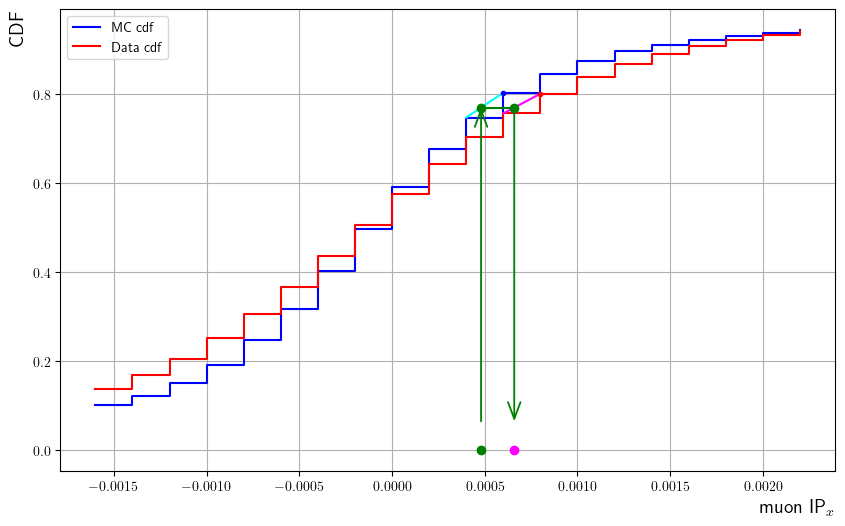

In [100]:
def prepare_hists():
    the_era = 'Run3_2022'
    the_dataset = 'mm'
    path =os.getcwd()+'/data/{era}/ip_corrections_{dataset}.root'
    the_path = path.format(era=the_era, dataset=the_dataset)
    the_input = uproot.open(the_path)

    name_parser(the_input.keys()[3])
    h_mc = the_input['ip_y_1p2to2p1_MC;1']
    h_data = the_input['ip_y_1p2to2p1_data;1']
    bins = h_mc.axis().edges()
    bin_centers = ((bins[1:] + bins[:-1])/2)
    mc_vals = h_mc.values()
    mc_vals[0] = 0
    mc_vals[-1] = 0 
    mc_vals = mc_vals/np.sum(h_mc.values())
    
    data_vals = h_data.values()
    data_vals[0] = 0 
    data_vals[-1] = 0
    data_vals = data_vals/np.sum(h_data.values())
   
    mc_cdf = gaussian_filter1d(np.cumsum(mc_vals), sigma=1)
    data_cdf = gaussian_filter1d(np.cumsum(data_vals), sigma=1)
    corr_path = os.getcwd() + f"/output/ip_correction_{the_era}.json"
    correction_set = cl.CorrectionSet.from_file(corr_path)
    ip_corr = correction_set[f'ip_correction_{the_dataset}']

    return {'mc_cdf': mc_cdf,
            'mc_pdf': mc_vals,
            'data_cdf': data_cdf,
            'data_pdf': data_vals,
            'bins': bins,
            'bin_centers': bin_centers,
            'ip_corr': ip_corr}


h = prepare_hists()
plot_qm=True
cdf_only=False
if plot_qm:
    def clip(arr): return  arr[140:160]
else:
     def clip(arr): return arr[:20]
        
mc_pdf = h['mc_pdf']
data_pdf = h['data_pdf']
mc_cdf = h['mc_cdf']
data_cdf = h['data_cdf']
bin_centers = h['bin_centers']
bins = h['bins'][:-1]
ip_corr = h['ip_corr']
fig, ax = plt.subplots(figsize=(10, 6))
font = {'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 14,
    }
if plot_qm and not cdf_only:
    ax.step(clip(bins),clip(mc_cdf), color='blue', label='MC cdf',where='post')
    ax.step(clip(bins),clip(data_cdf),color='red', label='Data cdf',where='post')
    
    ip_mc_val=0.00048
    #ip_mc_val=-0.02998
    
    formula, ip_val_corr , par_dict = make_quantile_mapping(ip_mc_val,
                                                            bins,
                                                            mc_cdf,
                                                            data_cdf,
                                                            only_formula=False)
    idx = par_dict['idx']
    idy = par_dict['idy']
    mc_cdf_val =  par_dict['mc_cdf_val']
    ax.plot(bins[idx],mc_cdf[idx], marker='o', color='blue', markersize=3,zorder=10,clip_on=False)
    
    ax.plot((bins[idx-1],bins[idx]),
            (mc_cdf[idx-1],mc_cdf[idx]),
            color='cyan')

    ax.plot(bins[idy],data_cdf[idy], marker='o', color='red', markersize=3,zorder=10,clip_on=False)
    
    ax.plot((bins[idy-1],bins[idy]),
            (data_cdf[idy-1],data_cdf[idy]),
            color='magenta')
    #ax.set_ylim(0,0.01)
    low ,_ = ax.get_ylim()
    ax.annotate('',
                color = 'green',
                xy=(ip_mc_val,mc_cdf_val),
                xytext=(ip_mc_val,low),
                arrowprops=dict(color='green',
                                arrowstyle='->,head_width=.15',
                                linewidth=1.3,
                                
                                mutation_scale=30,
                                shrinkB=0),
                va='top', ha='center',
                
                )
    ax.plot(ip_mc_val,mc_cdf_val, marker='o', color='green', markersize=6, zorder=3,clip_on=False)
    
    ax.plot((ip_mc_val,ip_val_corr),
            (mc_cdf_val,mc_cdf_val),
            color='green')
    ax.annotate('',
                color = 'green',
                xy=(ip_val_corr,low),
                xytext=(ip_val_corr,mc_cdf_val),
                arrowprops=dict(color='green',
                                arrowstyle='->,head_width=.15',
                                linewidth=1.3,
                                mutation_scale=30,
                                shrinkA=0),
                )
    ax.plot(ip_val_corr,mc_cdf_val, marker='o', color='green', markersize=6,zorder=10,clip_on=False)
    ax.plot(ip_mc_val,0, marker='o', color='green', markersize=6, zorder=3,clip_on=False)
    #ax.text(x = ip_val_corr+0.00040, y=low+0.03 , s=r'corrected IP$_{x}$', color = 'black', ha='center',fontdict=font)
    #ax.text(x = ip_mc_val-0.00018, y=low+0.03 , s=r'the IP$_{x}$', color = 'black', ha='center',fontdict=font)
    #ax.text(x = ip_mc_val-0.0002, y=mc_cdf_val+0.07 , s=r'CDF$_{\mathrm{MC}}(\mathrm{IP}_{x})$', color = 'black', ha='center',fontdict=font)
    #ax.text(x = ip_val_corr+0.0006, y=mc_cdf_val-0.04 , s=r'CDF$_{\mathrm{DATA}}=$CDF$_{\mathrm{MC}}(\mathrm{IP}_{x})$', color = 'black', ha='center',fontdict=font)
    corrected_IP = eval(formula.replace('x',str(ip_mc_val)))
    ax.plot(corrected_IP,0, marker='o', color='magenta', markersize=6, zorder=3,clip_on=False)
    ax.set_ylabel("CDF",loc='top',fontdict=font)
    ax.set_xlabel(r"muon IP$_x$",loc='right',fontdict=font)
    plt.grid()
    plt.legend()
    plt.savefig('ip_calibration_cdf.pdf')
elif cdf_only:
    ax.step(clip(bins),clip(mc_cdf), color='blue', label='MC cdf',where='post')
    ax.step(clip(bins),clip(data_cdf),color='red', label='Data cdf',where='post')
    ax.set_ylabel("CDF",loc='top',fontdict=font)
    ax.set_xlabel(r"muon IP$_x$",loc='right',fontdict=font)
    plt.grid()
    plt.legend()
    plt.yscale('log')
else:
    ax.set_ylabel("PDF",loc='top',fontdict=font)
    ax.set_xlabel(r"muon IP$_x$",loc='right',fontdict=font)
    corrected_ip_bins = ip_corr.evaluate(clip(bins), 'y', 1.5)
    ax.step(clip(bins),clip(mc_pdf), color='blue', label='MC pdf',where='post')
    ax.scatter(clip(bin_centers),clip(data_pdf), color='black', label='Data pdf')
    plt.grid()
    plt.legend()
    plt.savefig('ip_calibration_pdf.pdf')
    #ax.plot(corrected_ip_bins,clip(mc_pdf), color='limegreen', label='corrected mc pdf')



In [16]:
def prepare_hists():
    the_era = 'Run3_2022EE'
    the_dataset = 'mm'
    path =os.getcwd()+'/data/{era}/ip_corrections_{dataset}.root'
    the_path = path.format(era=the_era, dataset=the_dataset)
    the_input = uproot.open(the_path)

    name_parser(the_input.keys()[3])
    h_mc = the_input['ip_y_1p2to2p1_MC;1']
    h_data = the_input['ip_y_1p2to2p1_data;1']

    bins = h_mc.axis().edges()
    bin_centers = ((bins[1:] + bins[:-1])/2)
    mc_vals = h_mc.values()
    data_vals = h_data.values()
    mc_cdf = gaussian_filter1d(np.cumsum(mc_vals)/np.sum(mc_vals), sigma=1)
    data_cdf = gaussian_filter1d(
        np.cumsum(data_vals)/np.sum(data_vals), sigma=1)
    
    corr_path = os.getcwd() + f"/output/ip_correction_{the_era}.json"
    correction_set = cl.CorrectionSet.from_file(corr_path)
    ip_corr = correction_set[f'ip_correction_{the_dataset}']

    return {'mc_cdf': mc_cdf,
            'mc_pdf': mc_vals,
            'data_cdf': data_cdf,
            'data_pdf': data_vals,
            'bins': bins,
            'bin_centers': bin_centers,
            'ip_corr': ip_corr}


h = prepare_hists()
ip_corr = h['ip_corr']
file_mc = uproot.open("/home/stzakhar/merged.root")
file_data = uproot.open("/home/stzakhar/merged_data.root")

In [17]:
ipx = np.array(file_mc['ntuple']['ip_x_1'].array())
ipx_data = np.array(file_data['ntuple']['ip_x_1'].array())
ipx_data = ipx_data[abs(ipx_data)<0.03]
eta =  np.array(file_mc['ntuple']['eta_1'].array())
mask = abs(ipx)<0.03
ipx = ipx[mask]
eta = abs(eta[mask])
corrected_ipx = ip_corr.evaluate(ipx, 'x', eta)

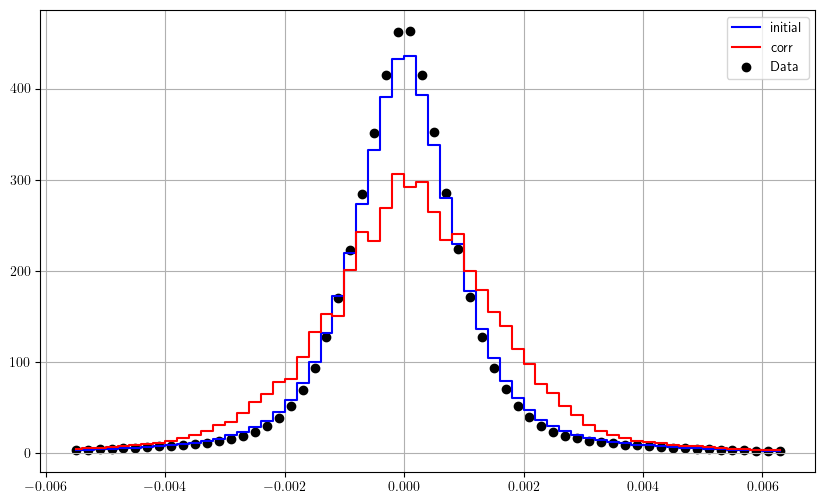

In [18]:
def clip(arr): return arr[120:180]
hist_ipx, bin_edges = np.histogram(ipx, bins=bins, density=True)
hist_ipx_data, _ = np.histogram(ipx_data, bins=bins, density=True)
hist_corr_ipx, _ = np.histogram(corrected_ipx, bins=bins, density=True)

bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
fig1, ax1 = plt.subplots(figsize=(10, 6))
font = {'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 14,
    }
ax1.step(clip(bin_centers),clip(hist_ipx), color='blue', label='initial',where='mid')
ax1.step(clip(bin_centers),clip(hist_corr_ipx),color='red', label='corr',where='mid')
ax1.scatter(clip(bin_centers),clip(hist_ipx_data),color='black',marker='o', label='Data')
#ax.set_ylabel("CDF, scalled PDF",loc='top',fontdict=font)
#ax.set_xlabel(r"IP$_x$",loc='right',fontdict=font)




plt.grid()
plt.legend()